# Run lunar lander - DQN

### Author: lyds 
***

Here we train our `ActionBot` using a deep Q learning approach

In [1]:
import sys
sys.path.append("..")

In [2]:
import gym
from uuid import uuid4
import os
import datetime
import numpy as np
from collections import deque
from pathlib import Path
import matplotlib.pyplot as plt

from src.episode_memory import LanderMemory, PoleMemory
from src.replay_memory import ReplayMemory
from src.action_bot import DQNActionBot

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext watermark

%watermark -u -n -t
%watermark -iv -v

last updated: Tue Mar 03 2020 09:50:07
gym   0.15.4
numpy 1.17.5
CPython 3.6.8
IPython 7.11.1


#### Set up training parameters
***

In [5]:
env_name = "LunarLander-v2"
total_episodes = 3000
max_time_steps = 512
env_seed = None
unique_run = None

load = False
save = True
rendering = False
replay = False

In [6]:
if unique_run is None:
    unique_run = uuid4()

#### Instantiate objects
***

In [7]:
def get_memory(env_name):
    if env_name == "LunarLander-v2":
        return LanderMemory()
    elif env_name == "CartPole-v0":
        return PoleMemory()
    else:
        raise ValueError

In [8]:
if total_episodes < 1:
    raise ValueError("Cannot have number of episodes less than 1")

env = gym.make(env_name)
action_bot = DQNActionBot(env)
if load:
    action_bot.load_dqn_weights(unique_run)
    
replay_memory = ReplayMemory()

Print out set training parameters

In [9]:
print(f"{action_bot.params}, \n{replay_memory.params}")

{'learn_rate': 0.0005, 'gamma': 0.98, 'tau': 0.001, 'epsilon_min': 0.025}, 
{'buffer_size': 10000, 'batch_size': 64, 'update_every': 4}


Save the best memory and reward history

In [10]:
best_memory = get_memory(env_name)
best_memory.total_reward = -np.inf
reward_vals = []
reward_window = deque(maxlen=100)

#### Train
***

We train using a Q-learning approach.

In [11]:
%%time
SUCCESS_LIMIT = 200
converged = False

# for logging of training result
logging_file = Path("../logging.txt")
if not logging_file.exists():
    logging_file.open(mode="a").write(
        "date, env, run_id, converged, episodes_to_complete, mean_reward\n"
    )

print("Starting training...")
for episode_number in range(total_episodes):
    
    # record memories
    episode_memory = get_memory(env_name)
    if env_seed is not None:
        episode_memory.seed = env_seed
    env.seed(episode_memory.seed)
    
    # set up episode run
    obs = env.reset()
    done = False
    t = 0

    while not done and t <= max_time_steps:
        if rendering:
            env.render()
        
        # get action
        action_bot.obs = obs
        action_bot.episode_n = episode_number
        action = action_bot.get_dq_action()
        new_obs, reward, done, _ = env.step(action)
        action_bot.next_obs = new_obs

        episode_memory.update(action, reward)
        experiences, learn = replay_memory.update(
            obs, action, reward, new_obs, done, episode_number
        )
        if learn:
            action_bot.learn(experiences)
        obs = new_obs
        t += 1

    env.close()

    if episode_number % 100 == 0 and episode_number > 0:
        print(
            f"Rolling average reward for episode {episode_number}: {np.mean(reward_window):.3f}"
        )

    if episode_number > 0 and episode_number % 500 == 0 and save:
        action_bot.save_dqn_weights(unique_run)

    reward_vals.append(episode_memory.total_reward)
    reward_window.append(episode_memory.total_reward)

    if best_memory.total_reward < episode_memory.total_reward:
        best_memory = episode_memory

    if np.mean(reward_window) > SUCCESS_LIMIT and not converged:
        converged = True
        print(f"------ Converged after {episode_number} episodes! ------")
        logging_file.open(mode="a").write(
            f"{datetime.datetime.now().isoformat()}, "
            f"{env_name}, "
            f"{unique_run}, "
            f"{converged}, "
            f"{episode_number + 1}, "
            f"{np.mean(reward_window)}\n"
        )

print(f"Highest total reward: {best_memory.total_reward}")
print(f"Rolling average reward: {np.mean(reward_window)}")

if save:
    action_bot.save_dqn_weights(unique_run)

Starting training...
Rolling average reward for episode 100: -225.142
Rolling average reward for episode 200: -42.257
Rolling average reward for episode 300: -23.504
Rolling average reward for episode 400: 20.962
Rolling average reward for episode 500: 132.876
Saved DQN weights!
Rolling average reward for episode 600: 141.230
Rolling average reward for episode 700: 152.832
Rolling average reward for episode 800: 141.381
Rolling average reward for episode 900: 136.808
Rolling average reward for episode 1000: 132.850
Saved DQN weights!
Rolling average reward for episode 1100: 131.301
Rolling average reward for episode 1200: 174.851
Rolling average reward for episode 1300: 104.224
Rolling average reward for episode 1400: 164.568
Rolling average reward for episode 1500: 165.523
Saved DQN weights!
Rolling average reward for episode 1600: 164.497
------ Converged after 1631 episodes! ------
Rolling average reward for episode 1700: 207.561
Rolling average reward for episode 1800: 204.831
Roll

Plot the training history with a rolling mean

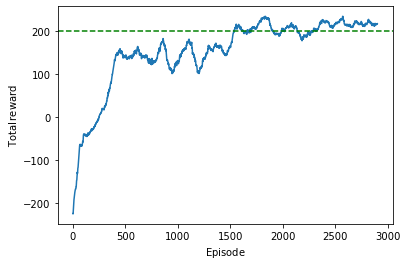

In [12]:
N = 100
plt.plot(np.convolve(reward_vals, np.ones((N,))/N, mode='valid'))
plt.axhline(SUCCESS_LIMIT, c="green", ls = "dashed")
plt.xlabel(r"$\mathrm{Episode}$")
plt.ylabel(r"$\mathrm{Total \/ reward}$")
plt.show()

Show the best episode that we experienced

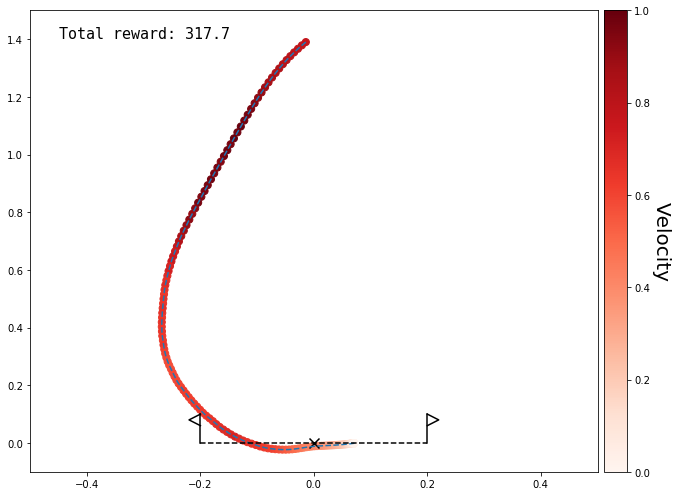

In [13]:
best_memory.replay(False, True)

#### Demo the model
***
Load in a model with fitted weights and run an episode


Loaded DQN weights!


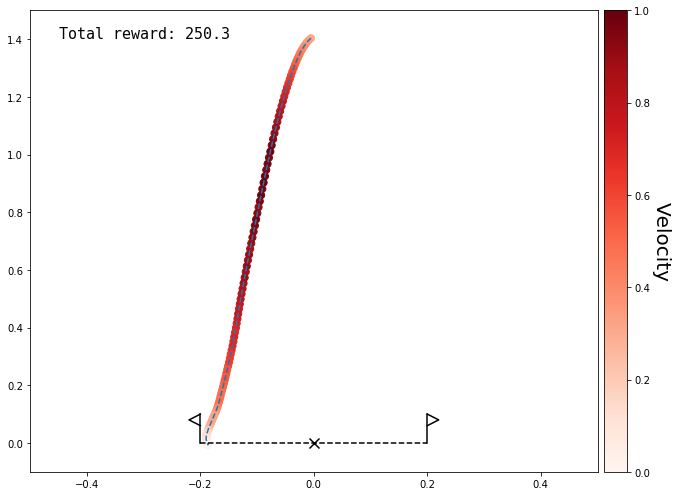

Total reward for memory: 250.26


In [15]:
env = gym.make(env_name)
action_bot = DQNActionBot(env)
unique_run = "9f29aaac-8273-40e2-a41e-d2754004123a"
action_bot.load_dqn_weights(unique_run)
action_bot.demo = True

# set up episode run
episode_memory = get_memory(env_name)
if env_seed is not None:
    episode_memory.seed = env_seed
env.seed(episode_memory.seed)
obs = env.reset()
done = False
t = 0

while not done and t <= max_time_steps:
    # get action
    action_bot.obs = obs
    action_bot.episode_n = 1
    action = action_bot.get_dq_action()
    # update action bot
    new_obs, reward, done, _ = env.step(action)   
    episode_memory.update(action, reward)
    obs = new_obs
    t += 1
    
episode_memory.replay(True, True)
print(f"Total reward for memory: {episode_memory.total_reward:.2f}")